In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cpymad.madx import Madx
import urllib

from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

pd.set_option('display.max_rows', None)
plt.ion()


This notebook shows how the linac to SPS transfer line concept was studied. Note that the result is not perfect has the goal was to validate the concept, investigate possible use of existing magnets available in the CERN storage and evaluate costs. Further study and optimisation is needed for the technical implementation and design step. 

The results of this study were dscussed in a Letter od Intent submitted to the SPS scientific comittee and available [here](https://cds.cern.ch/record/2640784/files/SPSC-EOI-018.pdf)

# TI2 line

Fast extraction from the SPS long straight section 6 tansfers beam to the TT60 tunnel and towards wither the HighRadMAt experimental area or towards the LHC.

 <img src="./ressources/layout_overview.png" style="width: 900px;"/>
 
 
 The concept is as follows
 - an electron linac will be placed in an existing building in the surface, in direct line with the TT60 tunnel, not showed in the figure above it would be far to the left
 - an electron beam transport line will be installed from the linac an connect to one of the existing lines for a fast injection into the SPS ring
 
 Note that in this concept, electrons would circulate opposite to the direction of hadrons. Electrons being negatively charged both direction and charge will be reversed wich means that optics and trajectory of the beam would be the same as for hadrons without needing to reverse any magnetic fields
 
 We will start by loading the stitched SPS+TI2 extraction line optics from the CERN accelerator optics repository [here](https://acc-models.web.cern.ch/acc-models/tls/2021/sps_extraction/tt60ti2_q26/stitched/)

In [3]:
# initialization of the madx object
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2021.01.27 12:19:46      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [4]:
# cloning the optics repositories
# ! git clone -n https://gitlab.cern.ch/acc-models/acc-models-tls.git
# ! cd acc-models-tls ; git checkout 7495fbaa1b7f4006258e9145e864ac02d25a1762

# ! git clone -n https://gitlab.cern.ch/acc-models/acc-models-sps.git
# ! cd acc-models-sps ; git checkout 32b347a0198dd17ee6009198857520b43413a39c

Now, with some minor changes, we will copy and run the commands used in the file `acc-models-tls/sps_extraction/tt60ti2_q26/stitched/general_sps_ti2_lhc_q26.madx` which is used to generate the stitched extraction optics from the SPS to the LHC, and the data used [in this plot](https://acc-models.web.cern.ch/acc-models/tls/2021/sps_extraction/tt60ti2_q26/stitched/), and created by F.M. Velotti.

The aim here is get the stitched sequence, but with only the optics and for now ignoring the extracted trajectory.

In [5]:
sps_extr_repo = 'acc-models-tls/sps_extraction/sps_ext_elements'
ti2_repo = 'acc-models-tls/sps_extraction/tt60ti2'
ti2_line_repo = 'acc-models-tls/sps_extraction/tt60ti2_q26/line'
tt60ti2_q26 = 'acc-models-tls/sps_extraction/tt60ti2_q26/stitched'
sps_repo = 'acc-models-sps'

madx.input('''
! MADX model of SPS-TT60-TI2 for LHC Q26 optics
!
! F.M.Velotti
!====================================================
 title, "SPS-TT60-TI2 LHC Q26 optics. Protons - 450 GeV/c";

 option, -echo;
 option, RBARC=FALSE;

 set, format="22.8e";
''')

madx.call(ti2_repo+'/ti2.seq')
madx.call(ti2_repo+'/ti2_apertures.dbx')
madx.call(ti2_line_repo+'/ti2_q26.str')

madx.input('''
beam,    sequence=ti2, particle=proton, pc= 450;
use,     sequence=ti2;

ex_g = beam->ex;
ey_g = beam->ey;
dpp = 1.5e-3;
''')
madx.call(ti2_repo+'/mbi_b3_error.madx')

Assigned field errors to 112 elements


In [6]:
madx.use('ti2')
# loading initial twiss parameters and transporting them along the ti2
madx.call(tt60ti2_q26+'/sps_tt60_ti2_lhc_q26.inp')
twiss_ti2 = madx.twiss(betx=madx.globals['betx0'], alfx=madx.globals['alfx0'], bety=madx.globals['bety0'], alfy=madx.globals['alfy0'], dx=madx.globals['dx0'], dpx=madx.globals['dpx0']).dframe()

#saving the length of that sequence
madx.globals['ti2_length'] = madx.table['summ'].length[0]

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:    -3.293442E-16  6.915897E-18  1.451206E-16 -1.191268E-18  1.473820E-16  0.000000E+00

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        3.18838428e+03        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        1.20391740e+01         0.00000000e+00         2.79993231e+02         3.09275960e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        1.41797143e+00         5.76586492e-16         2.12296565e-16         1.21801704e+01 

                   dq2                betymax                  dymax                  dyrms 
        0.00000000e+00         2.67287068e+

In [7]:
madx.call(sps_repo+'/sps.seq')
madx.call(sps_repo+'/strengths/lhc_q26.str')
madx.call(sps_extr_repo+'/fast_extraction_macros.cmdx')

madx.input('''
Beam, particle=PROTON,pc=450,exn=3.5e-6,eyn=3.5E-6;
BRHO      := BEAM->PC * 3.3356;

ex_g = beam->ex;
ey_g = beam->ey;
dpp = 1.5e-3;

use, sequence=SPS;

exec, install_extraction_points();

! Cycle machine to end at extraction point in LSS6
SEQEDIT, sequence=SPS;
CYCLE, START=EXTRPT_6_start;
FLATTEN;
ENDEDIT;

use, sequence = sps;

savebeta, label=extracting, place = EXTRPT_6_START;
twiss;
exec, replace_quad(qda.61910, qda.619.coil);
qda.619.coil, k1 :=  -0.16 * kqda;
''')
madx.globals['sps_length'] = madx.table['summ'].length[0]

++++++ info: element redefined: btv
++++++ info: element redefined: mbb
++++++ info: ex_g redefined
++++++ info: ey_g redefined
++++++ info: dpp redefined
++++++ info: seqedit - number of elements installed:  4
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        6.91150380e+03        -0.00000000e+00         1.92815906e-03         2.27734366e+01 

               

We have loaded both the ti2 and the sps seuquence, we can now stich them together

In [8]:
madx.input('''
sps_ti2: sequence, refer=entry, l= sps_length + ti2_length;
  sps, at=0;
  ti2, at=sps_length;
  endsequence;
''')


madx.use('sps_ti2')
twiss_sps_ti2 = madx.twiss(beta0='extracting').dframe()

enter Twiss module
 Found 6 initial orbit vector values from twiss command. 
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:    -3.293442E-16  6.915897E-18  1.451206E-16 -1.191268E-18  1.473820E-16  0.000000E+00

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        1.00998881e+04        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        3.81704717e+01         0.00000000e+00         2.81022398e+02         4.76777511e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        2.16521363e+00         5.76586492e-16         9.04283321e-17         3.83607205e+01 

                   dq2                betymax                  dymax          

We can now plot the complete optics of the SPS followed by the TI2 line and up to the LHC. However, the plot bellow limits to the region around the extraction to make it more clear.

In [9]:
def plot_this_twiss(fig, twiss):
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 4, 4])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # top plot is synoptic
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0, twiss['s'].max()], [0, 0], 'k-')

    for _, row in twiss[twiss['keyword'].str.contains('quadrupole|rbend|sbend')].iterrows():
        if row['keyword'] == 'quadrupole':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], 0), row['l'], np.sign(row['k1l']),
                    facecolor='k', edgecolor='k'))
        elif (row['keyword'] == 'rbend' or 
              row['keyword'] == 'sbend'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))

    #2nd plot is beta functions
    ax2.set_ylabel(r'$\beta$ (m)')
    ax2.plot(twiss['s'], twiss['betx'], 'r-')
    ax2.plot(twiss['s'], twiss['bety'], 'b-')        

    #3rd plot is dispersion functions
    ax3.set_ylabel('D (m)')
    ax3.plot(twiss['s'], twiss['dx'], 'r-')
    ax3.plot(twiss['s'], twiss['dy'], 'b-')

    axnames = ax1.twiny()
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)
    ax1._shared_x_axes.join(ax1, axnames)

    ticks, ticks_labels = list(), list()
    for keyword in ['quadrupole', 'rbend', 'sbend']:
        sub_twiss = twiss[twiss['keyword'] == keyword]
        ticks += list(sub_twiss['s'])
        ticks_labels += list(sub_twiss.index)

    axnames.set_xticks(ticks)
    axnames.set_xticklabels(ticks_labels, rotation=90)

    ax3.set_xlabel('s (m)')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min(), twiss['s'].max())

<IPython.core.display.Javascript object>


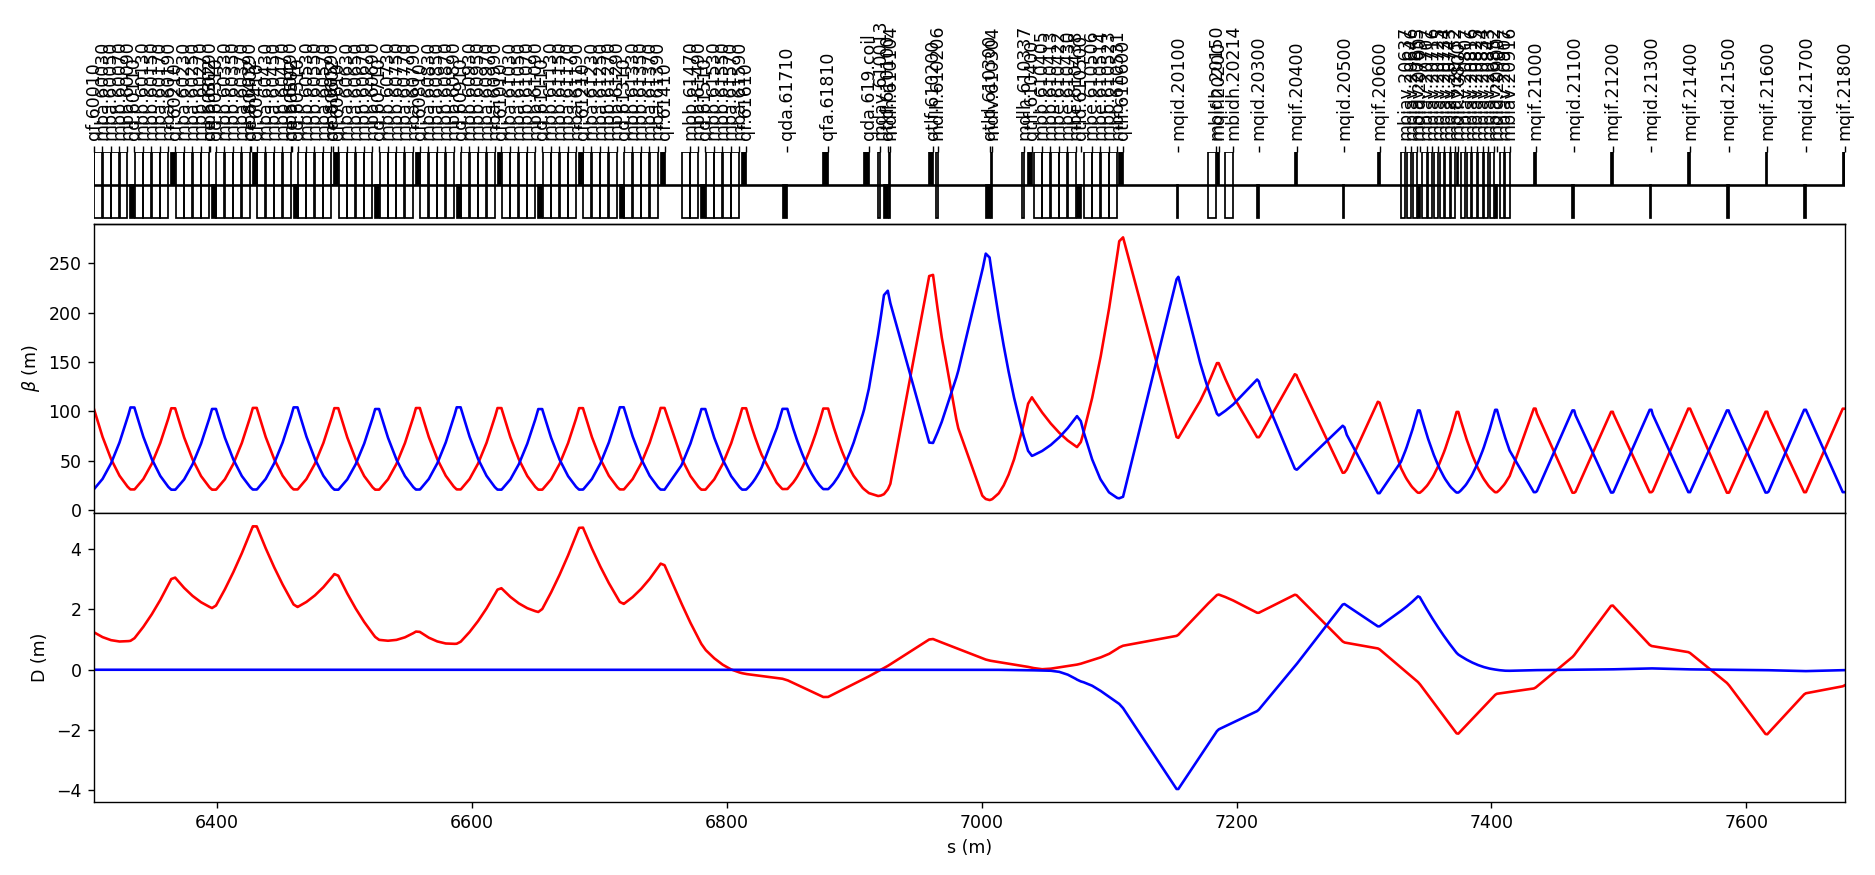

In [10]:
fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_sps_ti2.loc['qf.60010':'mqif.21800'])    

Now we will isolate the relevant part of the line, from the extraction point os the SPS labelled `EXTRPT_6` to where I decided to join the new beamline, downstream of the vertical corrector `MCIAV.20304` where I will place a marker named `END_SHARE_TI2`

In [11]:
twiss_forward_extrpt_6 = twiss_sps_ti2.loc['extrpt_6']
twiss_forward_end_share_ti2 = twiss_sps_ti2.loc['mciav.20304']

madx.command.seqedit(sequence='sps_ti2')
madx.command.flatten()
madx.command.install(element='END_SHARE_TI2', class_='marker', at=madx.elements['mciav.20304']['l']/2, from_='MCIAV.20304')
# madx.input('install, element=END_SHARE_TI2, class=marker, at=l.mciav/2, from=mciav.20304')
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  1
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [12]:
madx.use('sps_ti2')                 
madx.extract(sequence='sps_ti2', from_='extrpt_6', to='END_SHARE_TI2', newname='sps_to_handover')
madx.globals['sps_to_handover.l'] = twiss_forward_end_share_ti2['s']-twiss_forward_extrpt_6['s']


+++ extracting sequence sps_ti2 from extrpt_6:1 to end_share_ti2:1
+++ new sequence: sps_to_handover  with current length = 306.99798



enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     1.032867E-17  2.327536E-19 -1.123415E-24 -2.986549E-26  3.309432E-19  0.000000E+00

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        3.06997980e+02        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        8.66906852e-01         0.00000000e+00         2.76239697e+02         2.49217307e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        1.05248723e+00         1.19570262e-17         6.56415659e-18         6.84609332e-01 

                   dq2                betymax                  dymax                  dyrms 
        0.00000000e+00         2.59773520e+

<IPython.core.display.Javascript object>


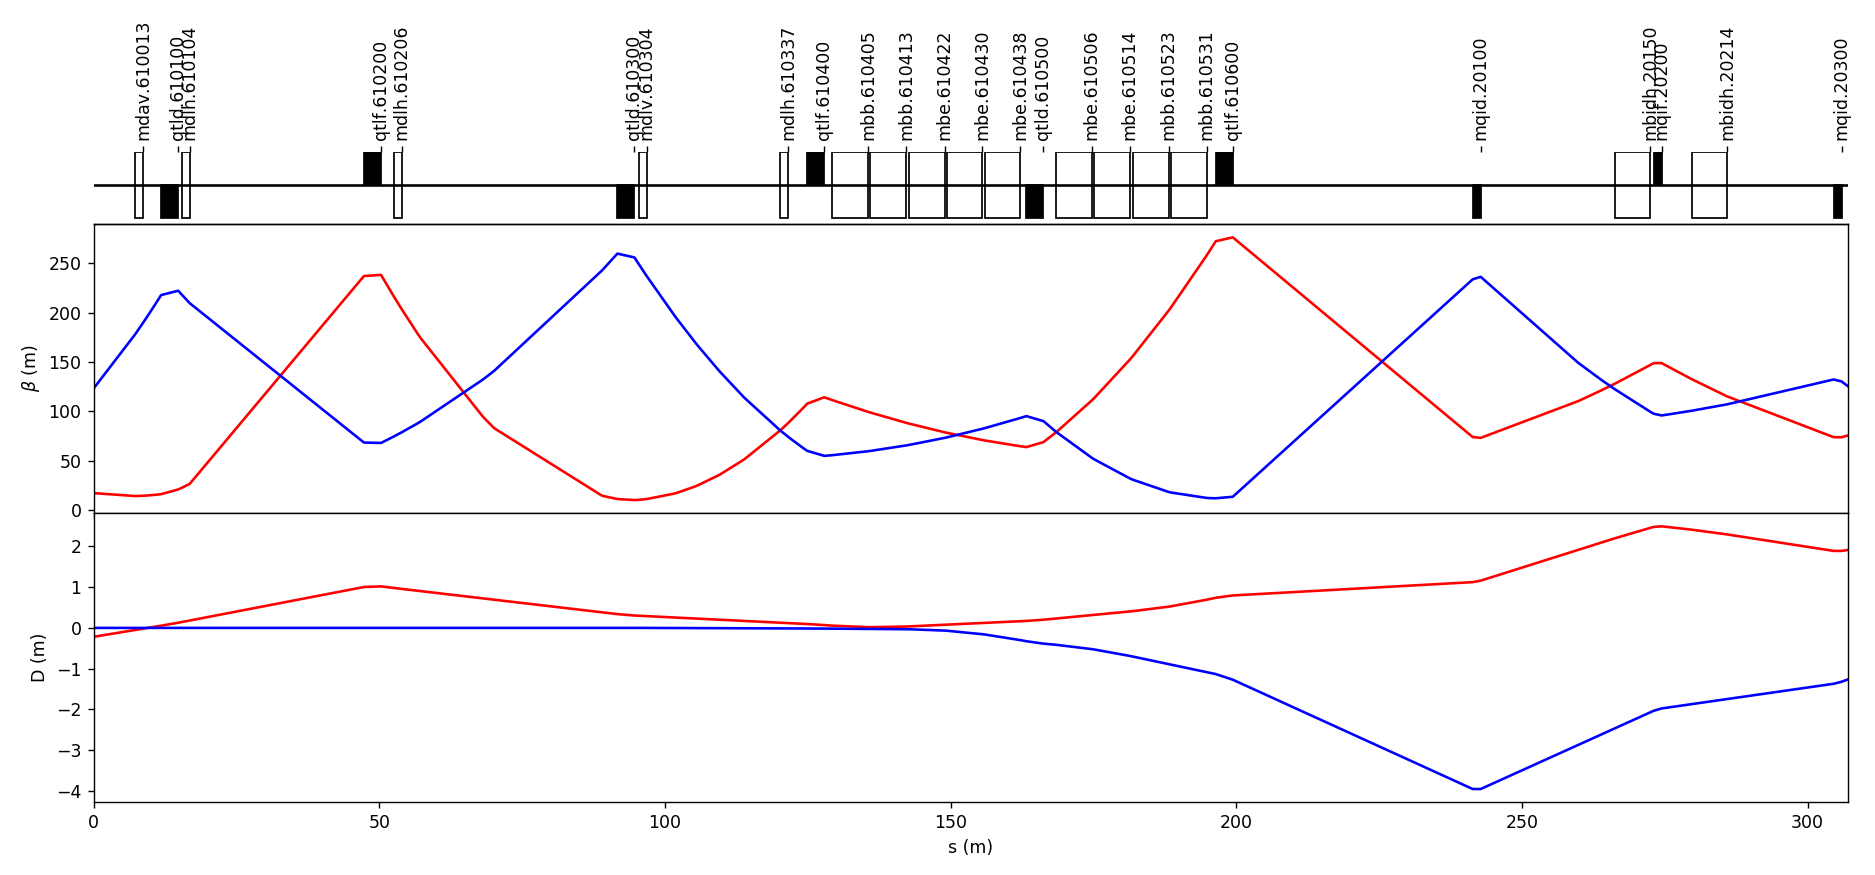

In [13]:
madx.use('sps_to_handover')
twiss_forward = madx.twiss(betx=twiss_forward_extrpt_6['betx'], alfx=twiss_forward_extrpt_6['alfx'], bety=twiss_forward_extrpt_6['bety'], alfy=twiss_forward_extrpt_6['alfy'], 
                           dx=twiss_forward_extrpt_6['dx'], dpx=twiss_forward_extrpt_6['dpx']).dframe()

fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_forward)    

# Pablo's work starts here

In [14]:
# Get the survey for the forward transport to later compare

madx.use(sequence = 'sps_to_handover')
survey_front = madx.survey(sequence = 'sps_to_handover').dframe()
end_coords = survey_front.iloc[-1]

## Yann: backward transport

In this project we aim at transporting the beam in the opposite direction. What does that entail and require on the model side ? Understand this and use MADX to produce the transport of the twiss parameters in the backward direction.

Use also the **SURVEY** module of MADX to see the position of elements in real space and make sure your reversal of the line also follow correctly real space !

### Pablo:

To get the correct transfer line for the electron beam we will:
 - Invert the order of all elements in the sequence using the REFLECT command.
 - Change the sign of all the bending angles in dipole magnets since we are coming from the opposite direction.
 - Use the twiss parameters at the end of the proton line as the initial twiss parameters. However, since we are going in the opposite direction we must apply the transformations (when needed)
 
 $$ s \rightarrow -s, \ x \rightarrow -x $$.


In [15]:
# First we make a copy of the sequence for protons

from_ = madx.sequence['sps_to_handover'].elements[0]
to = madx.sequence['sps_to_handover'].elements[-1]

madx.command.seqedit(sequence='sps_to_handover')
madx.command.flatten()
madx.command.install(element='START_POINT', class_='marker',
                     at=-from_['l']/2, from_=from_.name)
madx.command.install(element='END_POINT', class_='marker',
                     at=to['l']/2, from_=to.name)
madx.command.extract(sequence='sps_to_handover', from_='START_POINT',
             to='END_POINT',
             newname='handover_to_sps' )
madx.command.endedit()

+++ extracting sequence sps_to_handover from start_point:1 to end_point:1
+++ new sequence: handover_to_sps  with current length = 306.99798

++++++ info: seqedit - number of elements installed:  2
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [16]:
# Then we invert all elements

madx.command.seqedit(sequence='handover_to_sps')
madx.command.flatten()
madx.command.reflect()
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [17]:
#Check that element order was indeed reversed

print(madx.sequence['handover_to_sps'].elements)
print(madx.sequence['sps_to_handover'].elements)

[handover_to_sps$end, end_point, mciav.20304, mqid.20300, mbidh.20214, bpmi.20204, mqif.20200, mbidh.20150, tbse.20136, mqid.20100, startti2, qtlf.610600, bpck.610539, mbb.610531, mbb.610523, mbe.610514, mbe.610506, qtld.610500, mbe.610438, mbe.610430, mbe.610422, mbb.610413, mbb.610405, qtlf.610400, bpck.610340, mdlh.610337, ted.610321, btv.610317, bpck.610312, mdlv.610304, qtld.610300, btv.610252, bstl.610227, bfct.610225, bpck.610211, mdlh.610206, qtlf.610200, mdlh.610104, qtld.610100, btv.610018, bpck.610015, mdav.610013, spsextrpt_6_start_p_, extrpt_6, start_point, handover_to_sps$start]
[sps_to_handover$start, extrpt_6, spsextrpt_6_start_p_, mdav.610013, bpck.610015, btv.610018, qtld.610100, mdlh.610104, qtlf.610200, mdlh.610206, bpck.610211, bfct.610225, bstl.610227, btv.610252, qtld.610300, mdlv.610304, bpck.610312, btv.610317, ted.610321, mdlh.610337, bpck.610340, qtlf.610400, mbb.610405, mbb.610413, mbe.610422, mbe.610430, mbe.610438, qtld.610500, mbe.610506, mbe.610514, mbb.

### Pablo:

We also need to change the bending components of our machine, since now the beam is travelling in the opposite direction and with opposite charge. Note that madx does not seem to use the beam charge to compute angle kicks. Therefore, we adjust the horizontal bending components to point in the opposite direction:

$$ x \rightarrow -x$$,

which gives us the new field B' as (using madx variables)

$$B' = angle\cos(tilt)( -\hat{x}) + angle\sin{tilt}\hat{y}$$.

This is equivalent to just doing

$$tilt \rightarrow \pi-tilt$$

In [18]:
# Now we change the tilt

for ele in madx.sequence['handover_to_sps'].elements:
    try:
        if ele.angle != 0.0:
            ele.tilt = np.pi-ele.tilt

    except:
        print('exception at element {}'.format(ele.name))

exception at element handover_to_sps$end
exception at element end_point
exception at element mciav.20304
exception at element mqid.20300
exception at element bpmi.20204
exception at element mqif.20200
exception at element tbse.20136
exception at element mqid.20100
exception at element startti2
exception at element qtlf.610600
exception at element bpck.610539
exception at element qtld.610500
exception at element qtlf.610400
exception at element bpck.610340
exception at element ted.610321
exception at element btv.610317
exception at element bpck.610312
exception at element qtld.610300
exception at element btv.610252
exception at element bstl.610227
exception at element bfct.610225
exception at element bpck.610211
exception at element qtlf.610200
exception at element qtld.610100
exception at element btv.610018
exception at element bpck.610015
exception at element spsextrpt_6_start_p_
exception at element extrpt_6
exception at element start_point
exception at element handover_to_sps$start


In [19]:
# Change the the beam

madx.input('''
Beam, particle=ELECTRON,pc=15,exn=3.5e-6,eyn=3.5E-6, sequence = handover_to_sps;
''')

True

### Pablo:

It is important to take into account the changes we have made to our reference system when inputting the initial conditions for our twiss! 

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     6.496915E-18  2.171857E-19  2.232019E-25 -2.281374E-27  2.520724E-21  0.000000E+00

++++++ table: summ

                length                 orbit5                   alfa                gammatr 
        3.06997980e+02        -0.00000000e+00         0.00000000e+00         0.00000000e+00 

                    q1                    dq1                betxmax                  dxmax 
        8.66906852e-01         0.00000000e+00         2.76239697e+02         2.49217318e+00 

                 dxrms                 xcomax                 xcorms                     q2 
        1.02609081e+00         6.49691457e-18         2.11398945e-18         6.84609332e-01 

                   dq2                betymax                  dymax                  dyrms 
        0.00000000e+00         2.59773520e+

Text(0.5, 0.98, 'Forward Twiss')

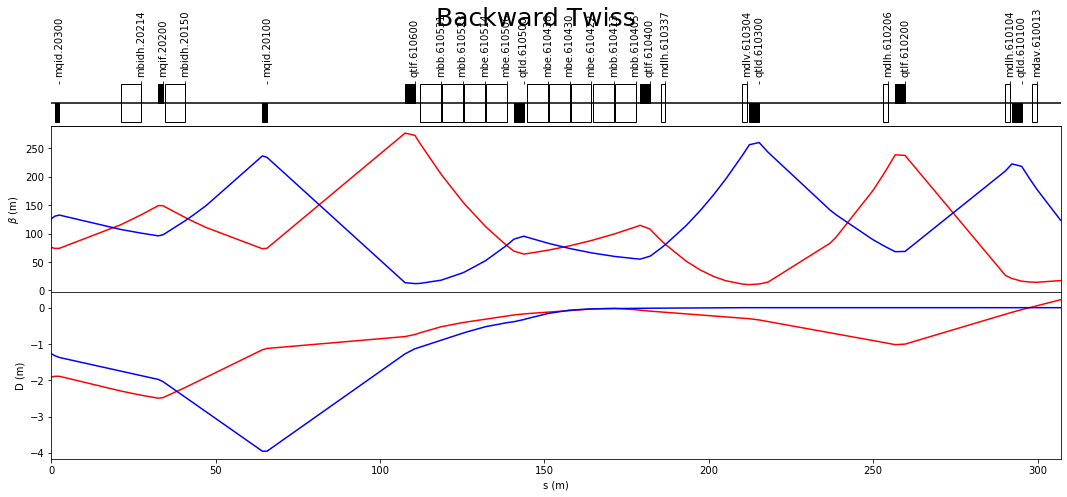

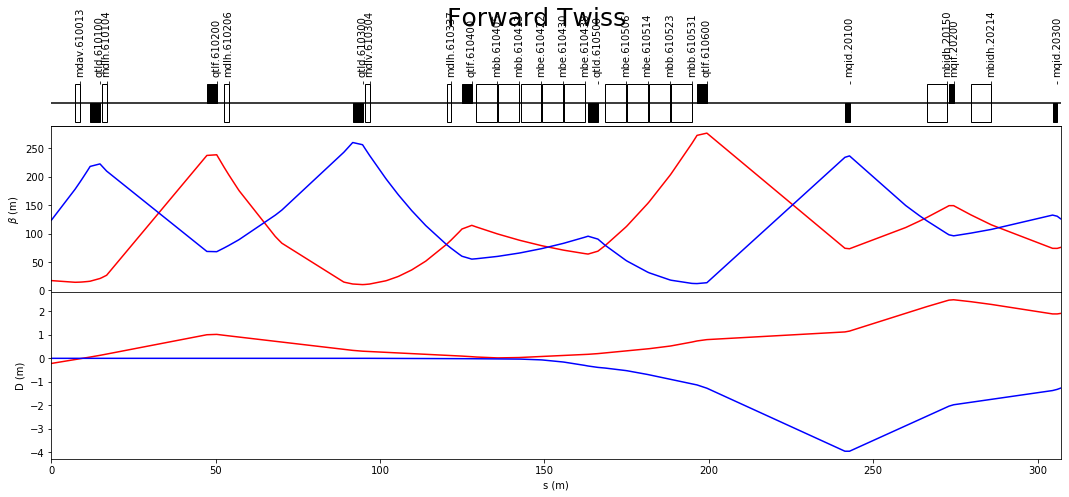

In [20]:
# Run twiss and compare to proton twiss

%matplotlib inline

twiss_backward_start = twiss_forward.iloc[-1]
madx.use('handover_to_sps')

twiss_backward = madx.twiss(betx=twiss_backward_start['betx'], alfx=-twiss_backward_start['alfx'],
                           bety=twiss_backward_start['bety'], alfy=-twiss_backward_start['alfy'], 
                           dx=-twiss_backward_start['dx'], dpx=twiss_backward_start['dpx'],
                            dy = twiss_backward_start['dy'], dpy=-twiss_backward_start['dpy'],
                            file = './test.tfs').dframe()


# We plot our twiss and the forward one

fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_backward)
fig.suptitle('Backward Twiss', fontsize = 25)

fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_forward) 
fig.suptitle('Forward Twiss', fontsize = 25)


### Pablo:
Great! The forward and backward twiss have the same optics propagating in the opposite directions! **Note that since we have reversed the x-coordinate, the horizontal dispersion function gets a change in sign, but the shape remains identical!**

We can compare the survey from the forward propagation to that of the backward propagation. We expect both to overlap if we set up the survey initial conditions right. 

- The initial (x,y,z) coordinates of the backward are given by the final (x,y,z) of the forward.

- The initial angles (theta, phi, psi) are given by the final ones  of the forward with the transformation (theta, phi - pi, psi-pi). This fall directly from the local transformations mentioned before.

In [21]:
madx.use(sequence = 'handover_to_sps')
survey_back = madx.survey(sequence = 'handover_to_sps',
                         x0 = end_coords.x, y0 = end_coords.y,
                         z0 = end_coords.z,
                          theta0 = end_coords.theta,
                         phi0 = end_coords.phi-np.pi,
                          psi0 = end_coords.psi-np.pi).dframe()

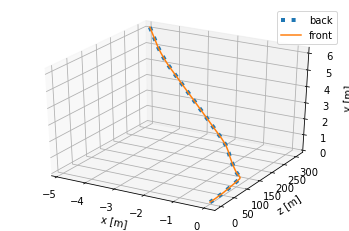

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(survey_back.x,survey_back.z,survey_back.y,
        label = 'back', linestyle = 'dotted', linewidth=4)
ax.plot(survey_front.x,survey_front.z,survey_front.y,
        label = 'front')

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_zlabel('y [m]')

ax.legend()

Voila! Both trajectories overlap perfectly.

## Yann: New line design

In our case the design of a new line will be done in 2 major steps, the geometry using dipoles and the control of the enveloppe using quadrupoles.

First use the magnet specifications provided and process the data to compare them, and chose the ones best suited to our application. This comparison should in particular show the maximum angle for dipoles and estimated minimum focal length for quadriupoles.

In [128]:
# Comparison of magnets

pc = 3.5 # GeV/c
m_e = 0.511e-3 # GeV
betagamma = pc/m_e
emit_n = 20e-6 # m
emit = emit_n / betagamma
brho = pc * 3.3356

dipoles = {'206': {'b0l': 0.15, 'l': 0.296},
           'BH2': {'b0': 1.52, 'l': 0.87, 'l_iron':0.51, 'h':0.045},
           'MBB': {'b0': 2.02, 'l': 6.7, 'l_iron':6.2, 'h':0.052},
           'MCW': {'b0l': 4.63, 'l': 3.5}, 
           'MTR': {'b0l': 7.5, 'l': 4.2}}

quads = {'CLIC1': {'l':0.1464, 'b1l':8.4},
          'Q100': {'l':1.484, 'b1l':12.04},
        'QFS': {'l':1.08, 'b1l':15.7},
          'QTL': {'l':3.3, 'b1l':73},
           'QTN': {'l':0.592, 'b1l':2.052},
            'QTR': {'l':0.43, 'b1l':0.4997},
            'QTS': {'l':1.835, 'b1l':37}}

for dipole, args in dipoles.items():
    if 'b0l' not in args.keys():
        dipoles[dipole]['b0l'] = (args['l_iron'] + args['h']) * args['b0']

for dipole, args in dipoles.items():
    dipoles[dipole]['k0l'] = args['b0l']/brho
dipoledf = pd.DataFrame(dipoles).T
    
for quad, args in quads.items():
    quads[quad]['k1l'] = args['b1l']/brho
quaddf = pd.DataFrame(quads).T
quaddf['f'] = 1/quaddf['k1l']

Text(0, 0.5, 'L [m]')

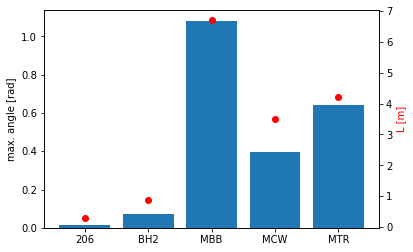

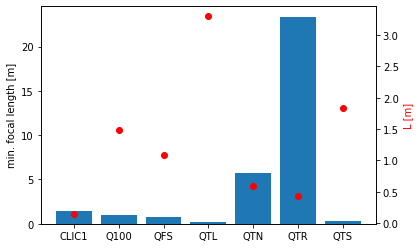

In [24]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.bar(dipoledf.index, dipoledf.k0l)
ax.set_ylabel('max. angle [rad]')
ax2.plot(dipoledf.index, dipoledf.l, linestyle='None',
        marker='o', zorder = 100, color = 'red')
ax2.set_ylabel('L [m]', color = 'red')

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.bar(quaddf.index, quaddf.f)
ax.set_ylabel('min. focal length [m]')
ax2.plot(quaddf.index, quaddf.l, linestyle='None',
        marker='o', zorder = 100, color = 'red')
ax2.set_ylabel('L [m]', color = 'red')

### Yann: geometrry

The geometry is constrainted by an existing tunnel (see ressources folder for drawing). This constraints the angle and location of dipole magnets that will impose the position of the vacuum chamber and the trajectory of the reference particle. Note that civil engineering is usually expensive, hence re-using exisinting tunnel or structure is optimal.

You may investigate the required geometry using the drawing provided. However, finding the needed trajectory requires more informations than those provided by the historical drawings. Therefore I list below the sequence needed :
 - handhover point of the beam from the linac.
 - 35 m of straight line
 - horizontal angle, towards the left, of 60.9 mrad
 - 60 m of straight line
 - vertical angle of 162 mrad, downwards
 - 326 m of straight line
 - vertical angle of 9.6 mrad, upwards
 - 109 m of straight line
 - vertical angle of 40.5 mrad, upwards
 - 71 m of straight line
 - horizontal angle, towards the left, of 34.3 mrad. This will place the trajectory in the axis of the line at the `END_SHARE_TI2` handover point
 - 1 m of straight line that will bring the line to the location of the handover marker
 
 



### Pablo:

For the dipoles, the CDR uses the BH2 type, which gives a maximum angle of roughly 72 mrad. This is a healthy amount and, due to their relatively short length (0.87 m) we can stack three of them in the section where 162 mrad is needed (see below for the required bends).

### Yann: envelope transport

The linac outputs a beam with a shape typical of a FODO cell with phase advance of 90 degrees, length of 5.3 m that ends on the focusing quadrupole. You should find an $\beta_x \simeq 9$ and $\beta_y \simeq 1.5$. This beam also has a relative momentum spread in the order of $10^{-3}$.

You should find the best arrangement of quadrupoles that transports and matches this beam to the handover point. The best arrangement uses the least number of quadrupoles, the smallest ones, and matches perfectly to the beam parameters at the handover point, in that order of priority.

### PABLO: Calculations about the FODO

We can calculate some basic parameters about our FODO given the maximum focal length of the chosen quadrupoles. For a FODO we have the useful formulas:

$$\sin(\mu / 2) = L / 2f $$,


The max/min beta functions at the center of the F/D quads are

$$\beta_{f,d} = \frac{2L(1\pm \sin(\mu/2)}{\sin(\mu)}$$.

### Priority 1: Least number of quadrupoles 

We want to maximize L, the distance between quadrupoles. At some point we will be limited by the maximum betas we can have from the constraints coming from the beam size. Taking a maximum beta of 150 m (comparable to the CDR) we get:

$$180 = \frac{4f\sin\mu/2(1+\sin\mu/2)}{\sin\mu}$$

Let's take a phase advance of pi/2 to simplify matters. Then we get

In [83]:
f_fodo = 160 / (2*np.sqrt(2)*(1+np.sqrt(2)/2))
kl_fodo = 1/f_fodo
l_fodo = np.sqrt(2) * f_fodo
print('Focusing length is {} m and the separation is {} m'.format(f_fodo, l_fodo))

Focusing length is 33.13708498984761 m and the separation is 46.862915010152406 m


### Pablo

### Priority 2: shortest quads

For this focusing length, the CLIC1 seems like a good candidate: it is very short and provides great strength. However, when looking at the specs, it only has a 10mm aperture, which is not enough for the beam we want to transport. The next shortest quadrupoles are the QTRs. Their minimum focal length is 20m so we can still use them for this application in the FODO cell. However, for the linac section where a bit more flexibility is needed, the QTNs are also quite short but provide 4 times the focusing strength. In short, the choices in the CDR seem well justified and I will set up a similar lattice.

In [84]:
def betmax_min(L, mu):
    betmax = 2 * L * (1+np.sin(mu/2))/np.sin(mu)
    betmin = 2 * L * (1-np.sin(mu/2))/np.sin(mu)
    return betmax, betmin

In [85]:
betmax, betmin = betmax_min(l_fodo, np.pi/2)
print(betmax, betmin)
maxbeamsize = np.sqrt(emit * betmax)
print('4 sigma beamsize: {} m'.format(4*maxbeamsize))

160.00000000000003 27.451660040609596
4 sigma beamsize: 0.0027340811985016103 m


### Priority 3: matching the optics

The final question is where we start the fodo cell so that its mismatch is minimal at the handover point. For this, we can drift the parameters we get from the last quad in the cell and try to adjust the distance s to the handover point in order to make the mismatch minimal.

First of all, we see that the last quad must be a F-quad, since the beam is entering ti2 with focusing in the horizontal and defocusing in the vertical. The drift equations for optical functions is:

$$\beta_1 = \beta_0 - 2\alpha_0 s + \gamma_0 s^2$$, 
$$\alpha_1 = \alpha_0 - \gamma_0 s$$,
$$\gamma_1 = \gamma_0$$

For a thin quadrupole:

$$\beta_1 = \beta_0$$,
$$\alpha_1 = \alpha_0 + kl\beta$$,
$$\gamma_1 = (1+\alpha_1^2)/\beta_1$$

Note that kl here corresponds to half the total strength of the f-quad, since we will propagate the parameters from the center of the quad. 

We will set up a cost function of the form:

$$ C = |(\beta_{end} - \beta_{handover})| + |0.1 * (\alpha_{end} - \alpha_{handover})|$$


In [86]:
def drift_optics(s, beta0, alpha0):
    gamma0  = (1 + alpha0**2) / beta0
    beta1 = beta0 - 2 * alpha0 * s + gamma0 * s**2
    alpha1 = alpha0 - gamma0 * s
    gamma1 = gamma0
    return beta1, alpha1, gamma1

def kick_optics(beta0, alpha0, kl):
    beta1 = beta0
    alpha1 = alpha0 + kl * beta0
    gamma1 = (1 + alpha1**2)/beta1
    return beta1, alpha1, gamma1

def cost_fun(beta1, beta2, alpha1, alpha2):
    return np.abs(beta1-beta2) + 0.1*np.abs(alpha1-alpha2)


The best s separation is 39.297658862876254 m


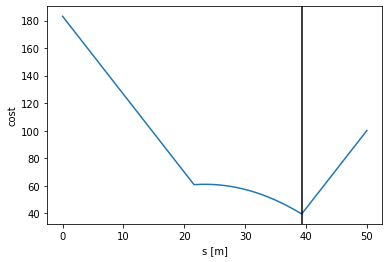

In [87]:
# get the optics after the quad

betx_after, alfx_after, gammax_after = kick_optics(betmax, 0, 0.5*kl_fodo)
bety_after, alfy_after, gammay_after = kick_optics(betmin, 0, -0.5*kl_fodo)

# set up s-scan
sarray = np.linspace(0, 50, 300)
betaxarray, alphaxarray, gammaxarray = drift_optics(sarray, betx_after, alfx_after)
betayarray, alphayarray, gammayarray = drift_optics(sarray, bety_after, alfy_after)

costx = cost_fun(betaxarray, twiss_backward_start.betx, alphaxarray, -twiss_backward_start.alfx)
costy = cost_fun(betayarray, twiss_backward_start.bety, alphayarray, -twiss_backward_start.alfy)
total_cost = costx + costy
ideal_s = sarray[total_cost.argmin()]

plt.plot(sarray, total_cost)
plt.xlabel('s [m]')
plt.ylabel('cost')
plt.axvline(ideal_s, color = 'black')

print('The best s separation is {} m'.format(ideal_s))

In [88]:
dipoledf

,b0,b0l,h,k0l,l,l_iron
206,NaN,0.15000,NaN,0.012848,0.296,NaN
BH2,1.52,0.84360,0.045,0.072259,0.870,0.51
MBB,2.02,12.62904,0.052,1.081754,6.700,6.20
MCW,NaN,4.63000,NaN,0.396587,3.500,NaN
MTR,NaN,7.50000,NaN,0.642420,4.200,NaN


In [89]:
quaddf

,b1l,k1l,l,f
CLIC1,8.4000,0.719511,0.1464,1.389833
Q100,12.0400,1.031299,1.4840,0.969651
QFS,15.7000,1.344800,1.0800,0.743605
QTL,73.0000,6.252891,3.3000,0.159926
QTN,2.0520,0.175766,0.5920,5.689376
QTR,0.4997,0.042802,0.4300,23.363218
QTS,37.0000,3.169273,1.8350,0.315530


### Pablo:

Now it's time to construct the lattice, using the guidelines we have developed until now.

In [113]:
madx = Madx()

madx.input('''
Beam, particle=ELECTRON, pc=15;
BRHO      := BEAM->PC * 3.3356;
''')

# Define relevant elements

define_eles = '''
kqtrf = {};
kqtrd = -{};
BH2: sbend, l = 0.87;
QTN: quadrupole, l = 0.592;
QTR: quadrupole, l = 0.43;
QTRf: QTR, k1 := kQTRf;
QTRd: QTR, k1 := kQTRd;
'''.format(1/(0.43*f_fodo), 1/(0.43*f_fodo))

madx.input(define_eles)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2021.01.27 16:48:33      +
  ++++++++++++++++++++++++++++++++++++++++++++


True

In [114]:
# Following the CDR we will have a linac matching + FODO sections

linac_seq = '''
ddip = BH2->l;
dlinac = 35 + 4*ddip + 60;

linac_seq: sequence, l=dlinac, refer=entry;
    LINAC_HANDOVER: marker, at = 0;
    QTN1: qtn, at = 0, k1 := kqtn1;
    QTN2: qtn, at = 35/3, k1 := kqtn2;
    QTN3: qtn, at = 2*35/3, k1 := kqtn3;
    BH21: bh2, at = 35, angle :=0.0609;
    QTN4: qtn, at = 35 + ddip, k1 := kqtn4;
    QTN5: qtn, at = 55, k1 := kqtn5;
    QTN6: qtn, at = 75, k1 := kqtn6;
    BH22: bh2, at = 95+ddip, angle =0.162/3, tilt = pi/2;
    BH23: bh2, at = 95+2*ddip, angle =0.162/3, tilt = pi/2;
    BH24: bh2, at = 95+3*ddip, angle =0.162/3, tilt = pi/2;
    FODO_HANDOVER: marker, at=dlinac;
endsequence;

'''

# From cdr we can roughly fit 6 fodo cells...

fodo_seq = '''
dfodo = 326 + ddip + 109 + ddip + 71 + ddip + 1;
dqtr = QTR->l;
dend = {}; ! Distance from last fodo quad to end of line;
dquad = {};
fodo_seq: sequence, l=dfodo, refer=entry;
    START_FODO: marker, at=0;
    QTRf1: QTRf, at=dfodo-10*dquad-dend;
    QTRd1: QTRd, at=dfodo-9*dquad-dend;
    QTRf2: QTRf, at=dfodo-8*dquad-dend;
    QTRd2: QTRd, at=dfodo-7*dquad-dend;
    QTRf3: QTRf, at=dfodo-6*dquad-dend;
    QTRd3: QTRd, at=dfodo-5*dquad-dend;
    QTRf4: QTRf, at=dfodo-4*dquad-dend;
    BH25: BH2, at=326, angle = -0.0096, tilt = pi/2;
    QTRd4: QTRd, at=dfodo-3*dquad-dend;
    QTRf5: QTRf, at=dfodo-2*dquad-dend;
    QTRd5: QTRd, at=dfodo-1*dquad-dend;
    BH26: BH2, at=326 + ddip + 109, angle=-0.0405, tilt = pi/2;
    QTRf6: QTRf, at=dfodo-dend;
    BH27: BH2, at=dfodo-ddip-1, angle=0.0343;
    END_FODO: marker, at=dfodo;
endsequence;
'''.format(ideal_s, l_fodo)

linac_ti2_seq = '''
linac_ti2: sequence, refer=entry, l= dlinac + dfodo;
  linac_seq, at=0;
  fodo_seq, at=dlinac;
  endsequence;
'''

madx.input(linac_seq)
madx.input(fodo_seq)
madx.input(linac_ti2_seq)
madx.use('linac_seq')
madx.use('fodo_seq')
madx.use('linac_ti2')

In [134]:
# We try to match the line to the start of ti2
dispersion = True
vary_fodo = True

beta0_linac = {'betx': 9, 'bety': 1.5} # alfas are 0 at Fquad
params_ti2 = twiss_backward.iloc[-1]

if dispersion:
    
    constraint_end = {'range_':'#e', 'betx':params_ti2.betx,
                     'alfx':params_ti2.alfx, 'bety':params_ti2.bety,
                     'alfy':params_ti2.alfy, 'dx':params_ti2.dx,
                     'dpx':params_ti2.dpx, 'dy':params_ti2.dy, 
                     'dpy':params_ti2.dpy}
    
else:
    constraint_end = {'range_':'#e', 'betx':params_ti2.betx,
                     'alfx':params_ti2.alfx, 'bety':params_ti2.bety,
                     'alfy':params_ti2.alfy} 




with madx.batch():

    madx.command.match(sequence='linac_ti2', **beta0_linac)

    madx.command.constraint(**constraint_end)
    madx.input('CONSTRAINT, weight=1, range=#s/#e, betx<300;')
    madx.input('CONSTRAINT, weight=1, range=#s/#e, bety<300;')
    madx.input('CONSTRAINT, range=qtrf2, betx={}, bety={};'.format(betmax, betmin))
    madx.input('CONSTRAINT, range=qtrf3, betx={}, bety={};'.format(betmax, betmin))


    madx.command.vary(step=1e-4, name='kqtn1',lower=-quaddf['k1l']['QTN']/quaddf['l']['QTN'],
                      upper=quaddf['k1l']['QTN']/quaddf['l']['QTN'])
    madx.command.vary(step=1e-4, name='kqtn2',lower=-quaddf['k1l']['QTN']/quaddf['l']['QTN'],
                      upper=quaddf['k1l']['QTN']/quaddf['l']['QTN'])
    madx.command.vary(step=1e-4, name='kqtn3',lower=-quaddf['k1l']['QTN']/quaddf['l']['QTN'],
                      upper=quaddf['k1l']['QTN']/quaddf['l']['QTN'])
    madx.command.vary(step=1e-4, name='kqtn4',lower=-quaddf['k1l']['QTN']/quaddf['l']['QTN'],
                      upper=quaddf['k1l']['QTN']/quaddf['l']['QTN'])
    madx.command.vary(step=1e-4, name='kqtn5',lower=-quaddf['k1l']['QTN']/quaddf['l']['QTN'],
                      upper=quaddf['k1l']['QTN']/quaddf['l']['QTN']/quaddf['l']['QTN'])
    madx.command.vary(step=1e-4, name='kqtn6',lower=-quaddf['k1l']['QTN']/quaddf['l']['QTN'],
                      upper=quaddf['k1l']['QTN']/quaddf['l']['QTN'])
    
    if vary_fodo:
        madx.command.vary(step=1e-4, name='kqtrf',lower=0,
                          upper=quaddf['k1l']['QTR']/quaddf['l']['QTR'])

    madx.simplex(calls=30000, tolerance=1e-10)
    madx.endmatch()

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            608.09                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       1.724309882                  0        369.1572293        7.482546102 

             dxrms             xcomax             xcorms                 q2 
       4.165908679                  0                  0        1.797596306 

               dq2            betymax              dymax              dyrms 
                 0        385.2873146        8.794534427        4.070489568 

            ycomax             ycorms             deltap            synch_1 


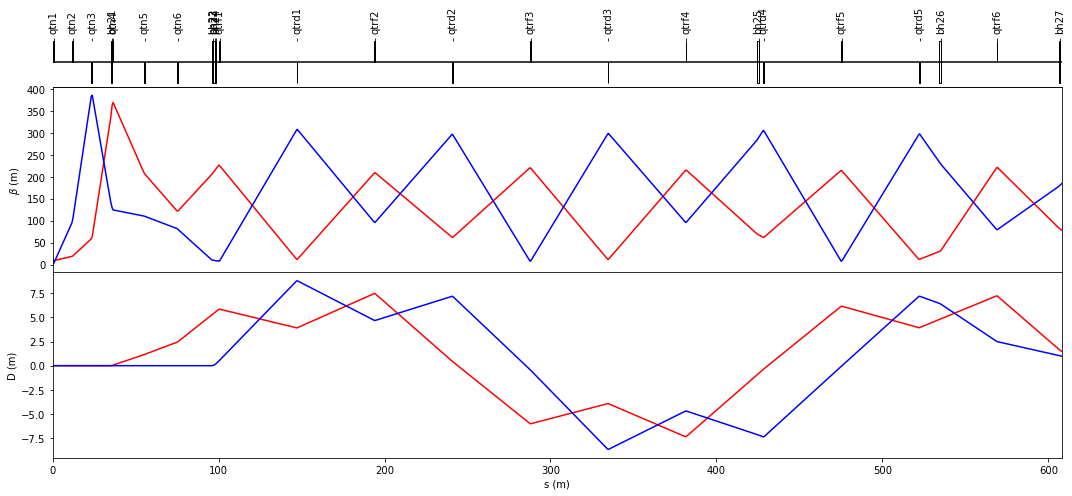

In [123]:
madx.use('linac_ti2')
twiss_linac_ti2 = madx.twiss(**beta0_linac).dframe()
fig = plt.figure(figsize=(15, 7))
plot_this_twiss(fig, twiss_linac_ti2)

Here we have it! The match is not perfect, but one could probably optimise this design further by playing with the phase advance at the fodo cell, the distance between the quads in the linac matching section and so on. For the beam envelopes we use the momentum spread and the emittance. I choose 4 sigma for the transverse size:

Text(0, 0.5, 'size [mm]')

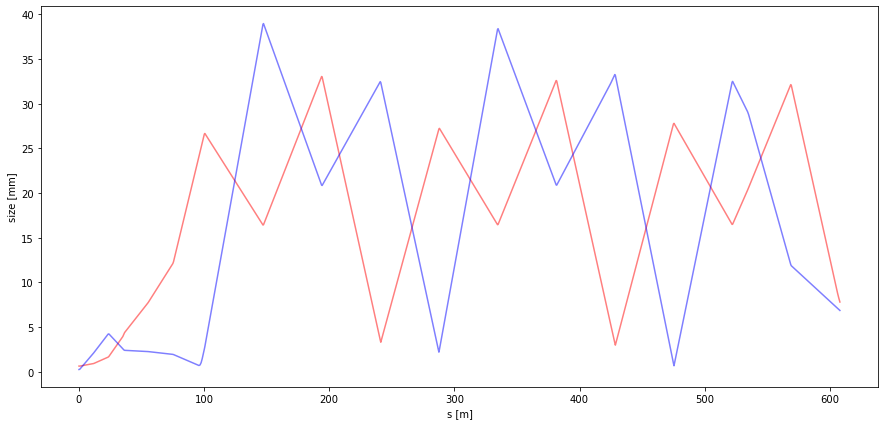

In [136]:
dpp = 1e-3
size_x = 4 * np.sqrt(emit * twiss_linac_ti2.betx) + 4*np.abs(dpp * twiss_linac_ti2.dx)
size_y = 4 * np.sqrt(emit * twiss_linac_ti2.bety) + 4*np.abs(dpp * twiss_linac_ti2.dy)

plt.figure(figsize = (15, 7))
plt.plot(twiss_linac_ti2.s, 1000*size_x, color = 'red', alpha = 0.5)
plt.plot(twiss_linac_ti2.s, 1000*size_y, color = 'blue', alpha = 0.5)
plt.xlabel('s [m]')
plt.ylabel('size [mm]')

And that's the beam size!